# Latent Dirichlet Allocation 
---

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
current_folder = "/content/gdrive/My Drive/Workshop/TOM/"
os.chdir(current_folder)

In [ ]:
# datasets_link = "/content/gdrive/MyDrive/Master/3Entscheidung/AFVFND/SecondWeek/SecondAssignment/FakeNewsDetection/FakeNewsDatasets/04/"
# os.listdir(datasets_link)
    

## Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import re 
from nltk.stem import WordNetLemmatizer

In [ ]:
# 0: Fake, 1: Real
# dataset_link = os.path.join(datasets_link, "dataset.csv")
data = pd.read_csv("issues_plus_cleaned.csv")
# data = pd.read_csv("issues.csv")
data.head(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unnamed: 0.1,active_lock_reason,assignee,author_association,body,closed_at,comments,comments_url,created_at,draft,events_url,html_url,id,labels_url,locked,milestone,node_id,number,performed_via_github_app,reaction +1,reaction -1,reaction confused,reaction eyes,reaction heart,reaction hooray,reaction laugh,reaction rocket,reaction total_count,reaction url,repository_url,state,timeline_url,title,updated_at,url,clean_title,code_title
0,0,0,NaN,NaN,NONE,<!--\r\nThanks for raising a Spring Boot issue...,NaN,0,https://api.github.com/repos/spring-projects/s...,2021-12-08T04:22:27Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1073997023,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AA-Tf,28926,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Springboot does not handle webapplicationtype ...,2021-12-08T04:26:56Z,https://api.github.com/repos/spring-projects/s...,Springboot does not handle webapplicationtype ...,without code
1,1,1,NaN,NaN,NONE,https://github.com/spring-projects/spring-boot...,NaN,0,https://api.github.com/repos/spring-projects/s...,2021-12-08T03:14:11Z,False,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1073964145,https://api.github.com/repos/spring-projects/s...,False,NaN,PR_kwDOAGAU1s4viBbh,28925,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Replace if condition in catch block with catch...,2021-12-08T03:16:56Z,https://api.github.com/repos/spring-projects/s...,Replace if condition in catch block with catch...,without code


In [ ]:
real_news = data#.drop(data[data["clean"]=="0"].index)
real_news.head(2)

,Unnamed: 0,Unnamed: 0.1,active_lock_reason,assignee,author_association,body,closed_at,comments,comments_url,created_at,draft,events_url,html_url,id,labels_url,locked,milestone,node_id,number,performed_via_github_app,reaction +1,reaction -1,reaction confused,reaction eyes,reaction heart,reaction hooray,reaction laugh,reaction rocket,reaction total_count,reaction url,repository_url,state,timeline_url,title,updated_at,url,clean_title,code_title
0,0,0,NaN,NaN,NONE,<!--\r\nThanks for raising a Spring Boot issue...,NaN,0,https://api.github.com/repos/spring-projects/s...,2021-12-08T04:22:27Z,NaN,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1073997023,https://api.github.com/repos/spring-projects/s...,False,NaN,I_kwDOAGAU1s5AA-Tf,28926,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Springboot does not handle webapplicationtype ...,2021-12-08T04:26:56Z,https://api.github.com/repos/spring-projects/s...,Springboot does not handle webapplicationtype ...,without code
1,1,1,NaN,NaN,NONE,https://github.com/spring-projects/spring-boot...,NaN,0,https://api.github.com/repos/spring-projects/s...,2021-12-08T03:14:11Z,False,https://api.github.com/repos/spring-projects/s...,https://github.com/spring-projects/spring-boot...,1073964145,https://api.github.com/repos/spring-projects/s...,False,NaN,PR_kwDOAGAU1s4viBbh,28925,NaN,0,0,0,0,0,0,0,0,0,https://api.github.com/repos/spring-projects/s...,https://api.github.com/repos/spring-projects/s...,open,https://api.github.com/repos/spring-projects/s...,Replace if condition in catch block with catch...,2021-12-08T03:16:56Z,https://api.github.com/repos/spring-projects/s...,Replace if condition in catch block with catch...,without code


In [ ]:
import nltk
nltk.download('stopwords') 
nltk.download('wordnet')

lemm = WordNetLemmatizer()
def news_to_words(raw_news):
    if type(raw_news)==str:
        lower_case = raw_news.lower()
        letters_only = re.findall(r"[a-z]+", lower_case)
        stops = set(stopwords.words("english"))
        meaningful_words = [w for w in letters_only if not w in stops]
        lemmatized = [lemm.lemmatize(word) for word in meaningful_words]
        return (" ".join(lemmatized))
    else:
        return np.nan

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
real_news["clean"] = real_news["clean_title"].apply(news_to_words)
print(real_news.shape)
real_news.dropna(inplace=True)
print(real_news.shape)

(34237, 39)
(0, 39)


In [ ]:
# import pandas as pd
real_news = pd.read_csv("X_and_y")
real_news.head()

,Unnamed: 0,title,labels
0,0,springboot does not handle webapplicationtype ...,1
1,1,replace if condition in catch block with catch...,3
2,2,refactor condition in catch,4
3,3,add,1
4,4,include beans in,4


In [ ]:
X = real_news[["title"]]
y = real_news[["labels"]]
X.head(2)

,title
0,springboot does not handle webapplicationtype ...
1,replace if condition in catch block with catch...


In [ ]:
set(y["labels"])

{0, 1, 2, 3, 4, 5}

In [ ]:
import math
print(math.floor(67*0.7), math.ceil(67*0.7))
li = list(range(10))
print(li[:6], li[6:])
# left inclusive, right exclusive

46 47
[0, 1, 2, 3, 4, 5] [6, 7, 8, 9]


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)
split_index = math.floor(X.shape[0]*0.7)
X_train = X[:split_index]
X_test = X[split_index:]
X_train.shape, X_test.shape

((22069, 1), (9459, 1))

## Dimension

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_features=5000, max_df=0.7)
count_train = count_vectorizer.fit_transform(X_train["title"])
count_test = count_vectorizer.transform(X_test["title"])

In [ ]:
count_train

<22069x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 125107 stored elements in Compressed Sparse Row format>

In [ ]:
count_test

<9459x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 48083 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method="online", 
                                      random_state=100, batch_size=100, evaluate_every=-1,
                                      n_jobs=-1)

In [ ]:
lda_output = lda_model.fit_transform(count_train)

In [ ]:
print(lda_model)

LatentDirichletAllocation(batch_size=100, learning_method='online', n_jobs=-1,
                          random_state=100)


In [ ]:
from sklearn.model_selection import GridSearchCV

search_params = {"n_components": [6, 7, 8], 
                 "learning_decay": [.5, .7, .9],
                 "learning_method": ["online"]}

lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(count_train)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'learning_method': ['online'],
                         'n_components': [6, 7, 8]})

In [ ]:
best_lda_model = model.best_estimator_
print("The best model is: {}".format(model.best_params_))
print("The best likelihood score: {}".format(model.best_score_))
print("Model perplexity: {}".format(best_lda_model.perplexity(count_train)))

The best model is: {'learning_decay': 0.7, 'learning_method': 'online', 'n_components': 6}
The best likelihood score: -212837.06554615084
Model perplexity: 1332.4656871936565


In [ ]:
n_topics = [6, 7, 8]
# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

In [ ]:
model.cv_results_["params"]#["learning_decay"]==0.5

[{'learning_decay': 0.5, 'learning_method': 'online', 'n_components': 6},
 {'learning_decay': 0.5, 'learning_method': 'online', 'n_components': 7},
 {'learning_decay': 0.5, 'learning_method': 'online', 'n_components': 8},
 {'learning_decay': 0.7, 'learning_method': 'online', 'n_components': 6},
 {'learning_decay': 0.7, 'learning_method': 'online', 'n_components': 7},
 {'learning_decay': 0.7, 'learning_method': 'online', 'n_components': 8},
 {'learning_decay': 0.9, 'learning_method': 'online', 'n_components': 6},
 {'learning_decay': 0.9, 'learning_method': 'online', 'n_components': 7},
 {'learning_decay': 0.9, 'learning_method': 'online', 'n_components': 8}]

In [ ]:
model.cv_results_["mean_test_score"]

array([-213241.15200098, -215690.13580232, -217747.87193131,
       -212837.06554615, -215048.39576177, -217239.12711704,
       -213316.82479262, -215973.43505311, -218061.49843042])

In [ ]:
parameters = model.cv_results_["params"]
scores = model.cv_results_["mean_test_score"]

log_likelyhoods_5 = [round(score) for parameter, score in zip(parameters, scores) if parameter["learning_decay"]==0.5]
log_likelyhoods_7 = [round(score) for parameter, score in zip(parameters, scores) if parameter["learning_decay"]==0.7]
log_likelyhoods_9 = [round(score) for parameter, score in zip(parameters, scores) if parameter["learning_decay"]==0.9]
# list(zip(parameters, scores)

In [ ]:
# model.cv_results_
# log_likelyhoods_5

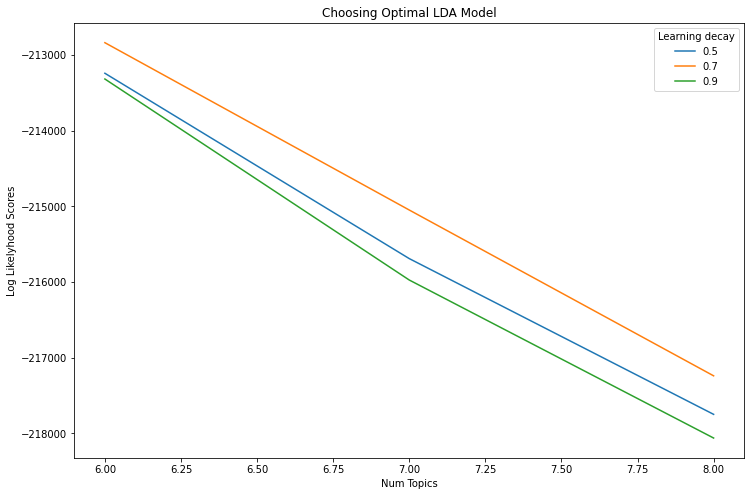

In [ ]:
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\n Topic #{}: ".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]])
        print(message)
        print("="*70)

In [ ]:
n_top_words = 40
print("\n Topics in the LDA model: ")
tf_feature_names = count_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, n_top_words)


 Topics in the LDA model: 

 Topic #0: to in with how the of when error and using type allow cannot be spring use change by from as at default server configuration tests more while annotation filter unable security types value null wrong user some for database mode

 Topic #1: for to update and in data query work chart field line pattern exception values object into from being list between way bar text android cloud other control command stream requests getting release event provide find columns correctly dubbo timeout like

 Topic #2: not the is on in when should with of does method and are be class if create an that remove or name version improve get documentation custom working has using have no used same fields show implement for message path

 Topic #3: for add support to and in new the table of all only feature by data adding methods check file one do key date cluster during or possible consider type failed annotations out module task memory single binding need execution service

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
def show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = list()
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [ ]:
topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=best_lda_model, n_words=15)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ["Word " + str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ["Topic " + str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,to,in,with,how,the,of,when,error,and,using,type,allow,cannot,be,spring
Topic 1,for,to,update,and,in,data,query,work,chart,field,line,pattern,exception,values,object
Topic 2,not,the,is,on,in,when,should,with,of,does,method,and,are,be,class
Topic 3,for,add,support,to,and,in,new,the,table,of,all,only,feature,by,data
Topic 4,to,in,of,for,from,fix,issue,use,the,set,as,test,after,java,with
Topic 5,can,on,multiple,with,request,is,index,to,code,when,missing,if,without,but,via


In [ ]:
topic_probability_scores = best_lda_model.transform(count_test)
print(topic_probability_scores)

[[0.05555573 0.72176616 0.05555571 0.05555575 0.05601079 0.05555587]
 [0.26702672 0.01860862 0.01857458 0.43656276 0.01853837 0.24068895]
 [0.40875482 0.04206412 0.04168064 0.04175777 0.42403582 0.04170682]
 ...
 [0.04166718 0.04166749 0.29179654 0.29130456 0.29189657 0.04166766]
 [0.04193749 0.04166726 0.54089043 0.29185043 0.04171813 0.04193626]
 [0.04166668 0.29165019 0.04166668 0.54168306 0.04166669 0.0416667 ]]


In [ ]:
def get_topic_text(topic, i):
    print("The news with item {} was labeled with the topic {} \n".format(i, topic))
    print(X_test.values[i])
    print("-"*30)

for i in range(10):
    get_topic_text((np.argmax(topic_probability_scores[i])), i)

The news with item 0 was labeled with the topic 1 

['effective interleaved survey']
------------------------------
The news with item 1 was labeled with the topic 3 

['tower only allows one takeoff and land per mission']
------------------------------
The news with item 2 was labeled with the topic 4 

['convert survey to waypoints']
------------------------------
The news with item 3 was labeled with the topic 5 

['feature request change telemetry']
------------------------------
The news with item 4 was labeled with the topic 0 

['shapefile overlay']
------------------------------
The news with item 5 was labeled with the topic 4 

['slider in survey menu']
------------------------------
The news with item 6 was labeled with the topic 2 

['battery capacity estimate based on voltage']
------------------------------
The news with item 7 was labeled with the topic 4 

['single axis accel calibration for plane']
------------------------------
The news with item 8 was labeled with th

In [ ]:
labels = [np.argmax(topic_probability_scores[index]) for index in range(X_test.shape[0]) ]

In [ ]:
len(labels)

9459

In [ ]:
y.values

array([[1],
       [3],
       [4],
       ...,
       [1],
       [1],
       [1]])

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y[split_index:].values, labels)

0.10730521196743842

In [ ]:
Too low!